In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import corner

from astropy.time import Time
from astropy import time, coordinates as coord, units as u
import astropy.constants as c

import time as timer

tangerine = ['#1a2754','#f9a919','#2ab59f','#e2721c','#db3e0e','#067bc1']

In [9]:
def normalize_lc(flux):
    #Returns median-normalized flux in units of parts-per-thousand
    mu = np.nanmedian(flux)
    return (flux/mu - 1) * 1e3

# **K2 light curve**

In [10]:
from astropy.io import fits
from scipy.signal import savgol_filter

lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c04/210800000/18897/hlsp_everest_k2_llc_210818897-c04_kepler_v2.0_lc.fits"
    
# Download the data
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
ktwo_texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
ktwo_texp /= 60.0 * 60.0 * 24.0

ktwo_x = lc["TIME"]
ktwo_y = lc["FLUX"]
ktwo_qual = lc["QUALITY"]    
    
# Mask bad data
m = np.isfinite(ktwo_x) & np.isfinite(ktwo_y)

# Median normalize flux and convert to parts per thousand
ktwo_y = normalize_lc(ktwo_y)
ktwo_yerr = 0.177*np.ones_like(ktwo_y)


# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(ktwo_x[m])

# Trim the light curve around the transit of planet e
m &= (abs(ktwo_x-2263.6229)<0.5)

# Make sure that the data type is consistent
ktwo_x = np.ascontiguousarray(ktwo_x[m], dtype=np.float64)
ktwo_y = np.ascontiguousarray(ktwo_y[m], dtype=np.float64)
ktwo_yerr = np.ascontiguousarray(ktwo_yerr[m], dtype=np.float64)
ktwo_qual = np.ascontiguousarray(ktwo_qual[m], dtype=np.float64)

print('XREF =', x_ref)

XREF = 2228.800412053417


In [11]:
#Note: upload the TICA light curve from the file manager at left
tica = np.loadtxt('../data/v1298_s43_o1_v2.txt')
tess_mjd  = tica[:,0] 
tess_f1   = tica[:,1]

tess_f1 = normalize_lc(tess_f1)


tess_bjd  = Time(tess_mjd, format='mjd').jd

# light travel time correction
greenwich = coord.EarthLocation.of_site('greenwich')
times = time.Time(tess_bjd, format='jd', location=greenwich)
moon = coord.get_moon(times)
delta_time = times.light_travel_time(moon)
tess_bkjd = times.value + delta_time.value - 2454833.0

tess_beg = tess_bkjd.min()
tess_end = tess_bkjd.max()
tess_mission_flag = ['tess']*len(tess_bkjd)
tess_texp = np.median(np.diff(tess_bkjd))
print(tess_texp)

tess_x = tess_bkjd
tess_y = tess_f1

# Select the data around the transit of planet e (we think)
tess_m = abs(tess_x-4648.8)<0.5

tess_x = np.ascontiguousarray(tess_x[tess_m], dtype=np.float64)
tess_y = np.ascontiguousarray(tess_y[tess_m], dtype=np.float64)

#mission_flag = tess_mission_flag

0.006944432854652405


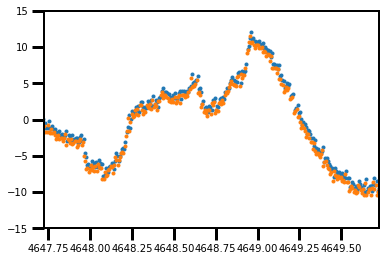

In [12]:
tica2 = np.loadtxt('../data/v1298_s43_o1_v2.txt')

tica2_mjd  = tica2[:,0] 
tica2_bjd  = Time(tica2_mjd, format='mjd').jd
tica2_bkjd = tica2_bjd - 2454833.0


tica2_f1   = normalize_lc(tica2[:,1])
tica2_f2   = normalize_lc(tica2[:,2])

plt.plot(tess_bkjd, tess_f1+0.5, '.')
plt.plot(tica2_bkjd, tica2_f1, '.')
#plt.xlim(4645.39920514-0.5,4645.39920514+0.5)
plt.xlim(4648.72281079-1, 4648.72281079+1)
#plt.ylim(-5,10)
plt.ylim(-15,15)
plt.show()

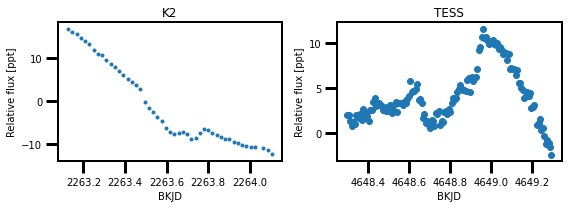

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

# Plot the data
ax1.errorbar(ktwo_x, ktwo_y, yerr=ktwo_yerr, fmt='.', label="K2")
ax1.set_xlabel("BKJD")
ax1.set_ylabel("Relative flux [ppt]")
ax1.set_title("K2")

ax2.scatter(tess_x, tess_y)
ax2.set_xlabel("BKJD")
ax2.set_ylabel("Relative flux [ppt]")
ax2.set_title("TESS")

plt.tight_layout()
plt.show()

In [19]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

n_pl = 1

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

def build_model(ktwo_mask=None, 
                tess_mask=None, 
                start=None,
                eccentric=False):
    
    if ktwo_mask is None:
        ktwo_mask = np.ones(len(ktwo_x), dtype=bool)
    if tess_mask is None:
        tess_mask = np.ones(len(tess_x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        
        # K2 transit depth and radius ratio
        log_depth_ktwo = pm.Normal("log_depth_ktwo", mu=np.log(4), sigma=2)                        
        ror_ktwo = pm.Deterministic("ror_ktwo", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth_ktwo), b
                                    ),
                                   )
        r_pl_ktwo = pm.Deterministic("r_pl_ktwo", ror_ktwo * r_star)
        r_pl_rade_ktwo = pm.Deterministic("r_pl_rade_ktwo", ror_ktwo * r_star * c.R_sun/c.R_earth)

        # Eccentricity and longitude of periastron
        if eccentric==True:
            ecs = pmx.UnitDisk("ecs", shape=(2, 1), testval=0.01 * np.ones((2, 1)))
            ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
            omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
            xo.eccentricity.vaneylen19("ecc_prior", 
                                        multi=True, shape=1, fixed=True, observed=ecc)
        
        elif eccentric==False:
            ecc = np.zeros(n_pl)
            omega = np.pi/2*np.ones(n_pl)
            
        
        # Ephemeris parameters
        t0 = pm.Normal("t0", mu=2263.6229, sd=0.1)
        log_period = pm.Normal("log_period", mu=np.log(48.67687959183674), sd=1e-5)
        #log_period = pm.Normal("log_period", mu=np.log(48.67687959183674), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))

        # Orbit models
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        ########################################################################################        
        ########################################################################################
        # Compute the model light curve
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        mean_ktwo = pm.Normal("mean_ktwo", mu=0.0, sd=10.0)

        light_curves_ktwo = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_ktwo, 
                t=ktwo_x[ktwo_mask], 
                texp=ktwo_texp) * 1e3
        )
        light_curve_ktwo = pm.math.sum(light_curves_ktwo, axis=-1) + mean_ktwo

        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_ktwo, 
                t=tess_x[tess_mask], 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess

        
        # Light curve noise and in-transit jitter
        log_sigma_lc_ktwo  = pm.Normal("log_sigma_lc_ktwo", mu=np.log(0.01*np.std(ktwo_y[ktwo_mask])), sd=10)
        log_sigma_jit_ktwo = pm.Normal("log_sigma_jit_ktwo", mu=np.log(0.02*np.std(ktwo_y[ktwo_mask])), sd=10) 
        yerr_ktwo = pm.Deterministic("yerr_ktwo", tt.exp(log_sigma_lc_ktwo) + tt.exp(2*log_sigma_jit_ktwo)*(light_curve_ktwo**2))
        
        
        # Light curve noise and in-transit jitter
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(tess_y[tess_mask])), sd=10)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(tess_y[tess_mask])), sd=10) 
        yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))

        resid_tess = pm.Deterministic("resid_tess", tess_y[tess_mask] - light_curve_tess)
        resid_ktwo = pm.Deterministic("resid_ktwo", ktwo_y[ktwo_mask] - light_curve_ktwo)

        #The parameters of the first SHO term
        log_rho_sho_ktwo = pm.Normal("log_rho_sho_ktwo", mu=0.0, sd=10)
        log_sigma_sho_ktwo = pm.Normal("log_sigma_sho_ktwo", mu=np.log(np.std(ktwo_y[ktwo_mask])), sd=10)

        #The parameters of the first SHO term
        log_rho_sho_tess = pm.Normal("log_rho_sho_tess", mu=0.0, sd=10)
        log_sigma_sho_tess = pm.Normal("log_sigma_sho_tess", mu=np.log(np.std(tess_y[tess_mask])), sd=10)


        kernel_ktwo = terms.SHOTerm(
            sigma=tt.exp(log_sigma_sho_ktwo),
            rho=tt.exp(log_rho_sho_ktwo),
            Q=1 / np.sqrt(2),
        )

        kernel_tess = terms.SHOTerm(
            sigma=tt.exp(log_sigma_sho_tess),
            rho=tt.exp(log_rho_sho_tess),
            Q=1 / np.sqrt(2),
        )        

        gp_ktwo = GaussianProcess(kernel_ktwo, t=ktwo_x[ktwo_mask], yerr=yerr_ktwo)
        gp_ktwo.marginal("transit_obs_ktwo", observed=resid_ktwo)

        gp_tess = GaussianProcess(kernel_tess, t=tess_x[tess_mask], yerr=yerr_tess)
        gp_tess.marginal("transit_obs_tess", observed=resid_tess)           

        map_soln = model.test_point
        
        map_soln = pmx.optimize(start=map_soln, vars=[log_rho_sho_ktwo, log_sigma_sho_ktwo,
                                                   log_rho_sho_tess, log_sigma_sho_tess,
                                                   mean_ktwo, mean_tess
                                                   ])

        map_soln = pmx.optimize(start=map_soln, vars=[b, log_depth_ktwo])

        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves_ktwo",
                 "light_curves_tess",
                 "gp_pred_ktwo",
                 "gp_pred_tess"],
                pmx.eval_in_model([light_curves_ktwo,
                                   light_curves_tess,
                                   gp_ktwo.predict(resid_ktwo),
                                   gp_tess.predict(resid_tess)], 
                                   map_soln),
            )
        )

    return model, map_soln, extras, orbit

model0, map_soln0, extras0, orbit0 = build_model()

optimizing logp for variables: [mean_tess, mean_ktwo, log_sigma_sho_tess, log_rho_sho_tess, log_sigma_sho_ktwo, log_rho_sho_ktwo]


message: Desired error not necessarily achieved due to precision loss.
logp: -6478.1342833816225 -> -255.62618012913802
optimizing logp for variables: [log_depth_ktwo, b]


message: Optimization terminated successfully.
logp: -255.62618012913524 -> -238.93250790586018
optimizing logp for variables: [log_sigma_sho_tess, log_rho_sho_tess, log_sigma_sho_ktwo, log_rho_sho_ktwo, log_sigma_jit_tess, log_sigma_lc_tess, log_sigma_jit_ktwo, log_sigma_lc_ktwo, mean_ktwo, mean_tess, log_period, t0, log_depth_ktwo, b, u_star, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -238.93250790586018 -> -172.22097414055585


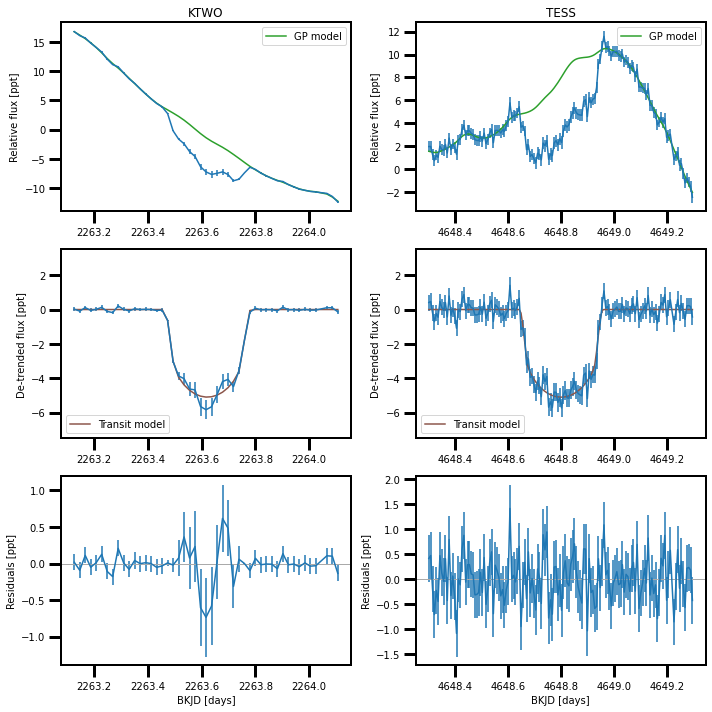

In [20]:
def plot_light_curve(soln, 
                     extras, 
                     xrange=[4641,4653], 
                     ktwo_mask=None,
                     tess_mask=None):

    
    if ktwo_mask is None:
        ktwo_mask = np.ones(len(ktwo_x), dtype=bool)

    if tess_mask is None:
        tess_mask = np.ones(len(tess_x), dtype=bool)        
        
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

    gp_mod_ktwo = extras["gp_pred_ktwo"] + soln["mean_ktwo"]
    gp_mod_tess = extras["gp_pred_tess"] + soln["mean_tess"]

    mod_sum_ktwo = np.sum(extras["light_curves_ktwo"], axis=-1)
    mod_sum_tess = np.sum(extras["light_curves_tess"], axis=-1)

    mod_ktwo = gp_mod_ktwo + mod_sum_ktwo
    mod_ktwo = gp_mod_tess + mod_sum_tess

    xdata = [ktwo_x[ktwo_mask], tess_x[tess_mask]]
    ydata = [ktwo_y[ktwo_mask], tess_y[tess_mask]]
    mission = ["ktwo", "tess"]

    for i in range(2):

        gp_mod = extras["gp_pred_"+mission[i]] + soln["mean_"+mission[i]]
        lc_mod = np.sum(extras["light_curves_"+mission[i]], axis=-1)

        yerr = soln["yerr_"+mission[i]]

        ax = axes[0][i]
        ax.errorbar(xdata[i], ydata[i], yerr=yerr)
        ax.plot(xdata[i], gp_mod, color="C2", label="GP model")
        ax.legend(fontsize=10)
        ax.set_ylabel("Relative flux [ppt]")
        ax.set_title(mission[i].upper())

        ax = axes[1][i]
        ax.errorbar(xdata[i], ydata[i] - gp_mod, yerr=yerr)
        ax.plot(xdata[i], lc_mod, label="Transit model", color="C5")          
        ax.legend(fontsize=10, loc=3)
        ax.set_ylabel("De-trended flux [ppt]")
        ax.set_ylim(-7.5,3.5)

        ax = axes[2][i]
        ax.errorbar(xdata[i], ydata[i] - gp_mod - lc_mod, yerr=yerr)
        ax.axhline(0, color="#aaaaaa", lw=1)
        ax.set_ylabel("Residuals [ppt]")
        ax.set_xlabel("BKJD [days]")

    plt.tight_layout()

    return fig
 
_ = plot_light_curve(map_soln0, extras0)

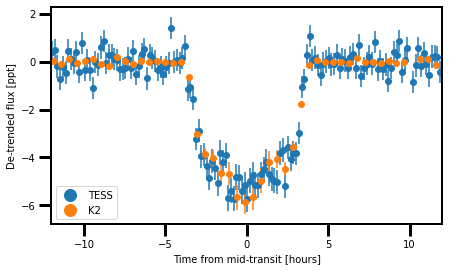

In [21]:
ktwo_ydet = ktwo_y - extras0["gp_pred_ktwo"] - map_soln0["mean_ktwo"]
tess_ydet = tess_y - extras0["gp_pred_tess"] - map_soln0["mean_tess"]

ktwo_yerr = map_soln0["yerr_ktwo"]
tess_yerr = map_soln0["yerr_tess"]

ktwo_fold = (ktwo_x - map_soln0["t0"] + 0.5 * map_soln0["period"]) % map_soln0["period"] - 0.5*map_soln0["period"]
tess_fold = (tess_x - map_soln0["t0"] + 0.5 * map_soln0["period"]) % map_soln0["period"] - 0.5*map_soln0["period"]

plt.errorbar(24*tess_fold, tess_ydet, yerr=tess_yerr, fmt="o", label='TESS')
plt.errorbar(24*ktwo_fold, ktwo_ydet, yerr=ktwo_yerr, fmt="o", label='K2')
plt.legend()
plt.xlim(-12,12)
plt.xlabel('Time from mid-transit [hours]')
plt.ylabel('De-trended flux [ppt]')
plt.gcf().set_size_inches(7,4)
plt.show()

# What are the possible periods for planet e? 
In the discovery paper we ruled out periods <36 days based on the fact that we didn't observe any additional transits of ~0.5% depth in the light curve. I'm **pretty sure** I'd stick by that statement! :) 

So if n is the number of transits between K2 and TESS we have a discrete set of possible periods, where we only need to consider n in the range of 1 to some number that maxes out when the implied period becomes less than 36 d

In [16]:
#for n in range(1, 70): 
#    print(n, (4648.79  - 2263.6229)/n)

## Take 2

38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


optimizing logp for variables: [mean_tess, mean_ktwo, log_sigma_sho_tess, log_rho_sho_tess, log_sigma_sho_ktwo, log_rho_sho_ktwo]


message: Optimization terminated successfully.
logp: -245.9167719239181 -> -226.9783609903277
optimizing logp for variables: [log_depth_ktwo, b]


message: Optimization terminated successfully.
logp: -226.97836099032764 -> -224.92306816491975
optimizing logp for variables: [log_sigma_sho_tess, log_rho_sho_tess, mean_tess, log_sigma_sho_ktwo, log_rho_sho_ktwo, mean_ktwo, tn, t0, log_depth_ktwo, b, u_star, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -224.92306816491975 -> -181.37777599308248


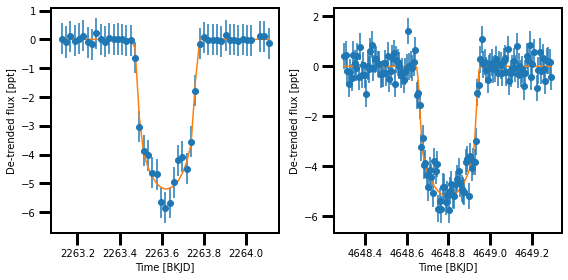

In [22]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

n_pl = 1

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

def discrete_period_gp_model(ktwo_mask=None, 
                             tess_mask=None, 
                             start=None):
    
    if ktwo_mask is None:
        ktwo_mask = np.ones(len(ktwo_x), dtype=bool)
    if tess_mask is None:
        tess_mask = np.ones(len(tess_x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        
        # K2 transit depth and radius ratio
        log_depth_ktwo = pm.Normal("log_depth_ktwo", mu=np.log(4.0), sigma=3)                        
        ror_ktwo = pm.Deterministic("ror_ktwo", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth_ktwo), b
                                    ),
                                   )
        r_pl_ktwo = pm.Deterministic("r_pl_ktwo", ror_ktwo * r_star)
        r_pl_rade_ktwo = pm.Deterministic("r_pl_rade_ktwo", ror_ktwo * r_star * c.R_sun/c.R_earth)
        
        # TESS transit depth and radius ratio
        #log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(4.0), sigma=3)                        
        #ror_tess = pm.Deterministic("ror_tess", 
        #                            star.get_ror_from_approx_transit_depth(
        #                                1e-3 * tt.exp(log_depth_tess), b
        #                            ),
        #                           )
        #r_pl_tess = pm.Deterministic("r_pl_tess", ror_tess * r_star)
        #r_pl_rade_tess = pm.Deterministic("r_pl_rade_tess", ror_tess * r_star * c.R_sun/c.R_earth)
        
        ecc = np.zeros(n_pl)
        omega = np.pi/2*np.ones(n_pl)
            
        
        # K2 transit midpoint
        t0 = pm.Normal("t0", mu=2263.6229, sigma=0.1)
        # TESS transit midpoint
        tn = pm.Normal("tn", mu=4648.79, sigma=0.1)

        #The parameters of the first SHO term
        mean_ktwo = pm.Normal("mean_ktwo", mu=0.0, sd=0.1) 
        log_rho_sho_ktwo = pm.Normal("log_rho_sho_ktwo", mu=0.0, sd=2.0)
        log_sigma_sho_ktwo = pm.Normal("log_sigma_sho_ktwo", mu=np.log(np.std(ktwo_y[ktwo_mask])), sd=10)

        #The parameters of the first SHO term
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=0.1)
        log_rho_sho_tess = pm.Normal("log_rho_sho_tess", mu=0.0, sd=2.0)
        log_sigma_sho_tess = pm.Normal("log_sigma_sho_tess", mu=np.log(np.std(tess_y[tess_mask])), sd=10)


        kernel_ktwo = terms.SHOTerm(
            sigma=tt.exp(log_sigma_sho_ktwo),
            rho=tt.exp(log_rho_sho_ktwo),
            Q=1 / np.sqrt(2),
        )

        kernel_tess = terms.SHOTerm(
            sigma=tt.exp(log_sigma_sho_tess),
            rho=tt.exp(log_rho_sho_tess),
            Q=1 / np.sqrt(2),
        )


        gp_ktwo = GaussianProcess(kernel_ktwo, t=ktwo_x[ktwo_mask], yerr=np.max(ktwo_yerr))
        gp_tess = GaussianProcess(kernel_tess, t=tess_x[tess_mask], yerr=np.max(tess_yerr))

        logls = []
        
        #Note: if we want to explore longer periods we need to decrease the lower end of this range!
        for n in range(38,60): 
            period = pm.Deterministic(f"period_{n}", (tn - t0) / n)

            # Orbit models
            orbit = xo.orbits.KeplerianOrbit(
              r_star=r_star,
              m_star=m_star,
              period=period,
              t0=t0,
              b=b,
              ecc=ecc,
              omega=omega,
              )

            # Compute light curve
            light_curves_ktwo = (
                                  star.get_light_curve(
                                      orbit=orbit, 
                                      r=r_pl_ktwo, 
                                      t=ktwo_x[ktwo_mask], 
                                      texp=ktwo_texp) * 1e3
                                )
            light_curve_ktwo = pm.math.sum(light_curves_ktwo, axis=-1) + mean_ktwo

            light_curves_tess = (
                                  star.get_light_curve(
                                      orbit=orbit, 
                                      r=r_pl_ktwo, 
                                      t=tess_x[tess_mask], 
                                      texp=tess_texp) * 1e3
                                )
            light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess

            resid_tess = tess_y[tess_mask] - light_curve_tess
            resid_ktwo = ktwo_y[ktwo_mask] - light_curve_ktwo

            logln_ktwo = gp_ktwo.log_likelihood(resid_ktwo)
            logln_tess = gp_tess.log_likelihood(resid_tess)

            logln = tt.sum(logln_ktwo) + tt.sum(logln_tess)

            pm.Deterministic(f"logl_{n}", logln)
            print(n)
            logls.append(logln)


        logl = tt.log(tt.sum(tt.exp(tt.stack(logls))))

        pm.Deterministic("logl", logl)
        pm.Potential("obs", logl)

        map_soln = model.test_point
        
        map_soln = pmx.optimize(start=map_soln, vars=[log_rho_sho_ktwo, log_sigma_sho_ktwo,
                                                      log_rho_sho_tess, log_sigma_sho_tess,
                                                      mean_ktwo, mean_tess
                                                   ])

        map_soln = pmx.optimize(start=map_soln, vars=[b, log_depth_ktwo])
        #map_soln = pmx.optimize(start=map_soln, vars=[b, log_depth_tess])

        map_soln = pmx.optimize(start=map_soln)


        # Plot the MAP solution
        lc_ktwo = pmx.eval_in_model(light_curve_ktwo, map_soln)
        lc_tess = pmx.eval_in_model(light_curve_tess, map_soln)
        res_ktwo = ktwo_y[ktwo_mask] - lc_ktwo
        res_tess = tess_y[tess_mask] - lc_tess
        
        fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

        ax1.errorbar(ktwo_x, ktwo_ydet, yerr=np.max(ktwo_yerr), fmt='o')
        ax1.plot(ktwo_x,lc_ktwo)

        ax2.errorbar(tess_x, tess_ydet, yerr=np.max(tess_yerr), fmt='o')
        ax2.plot(tess_x,lc_tess)

        for ax in [ax1,ax2]:
            ax.set_xlabel('Time [BKJD]')
            ax.set_ylabel('De-trended flux [ppt]')

        plt.tight_layout()
        plt.show()
        
        extras = dict(
                     zip(
                        ["light_curves_ktwo",
                          "light_curves_tess",
                          "gp_pred_ktwo",
                          "gp_pred_tess"],
                        pmx.eval_in_model([light_curves_ktwo,
                                            light_curves_tess,
                                            gp_ktwo.predict(resid_ktwo),
                                            gp_tess.predict(resid_tess)], 
                                            map_soln),
             )
         )

    return model, map_soln, orbit, extras

model1, map_soln1, orbit1, extras1 = discrete_period_gp_model()

In [23]:
random_seeds = [239081, 3409184, 9890418]
with model1:
    trace = pmx.sample(tune=500,
                        draws=5000,
                        start=map_soln1,
                        chains=1,
                       # cores=3,
                        return_inferencedata=True,
                        random_seed=random_seeds[0])

Sequential sampling (1 chains in 1 job)
NUTS: [log_sigma_sho_tess, log_rho_sho_tess, mean_tess, log_sigma_sho_ktwo, log_rho_sho_ktwo, mean_ktwo, tn, t0, log_depth_ktwo, b, u_star, r_star, m_star]


Sampling 1 chain for 500 tune and 5_000 draw iterations (500 + 5_000 draws total) took 1492 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [26]:
random_seeds = [239081, 3409184, 9890418]
with model1:
    trace1 = pmx.sample(tune=500,
                        draws=5000,
                        start=map_soln1,
                        chains=1,
                       # cores=3,
                        return_inferencedata=True,
                        random_seed=random_seeds[1])

Sequential sampling (1 chains in 1 job)
NUTS: [log_sigma_sho_tess, log_rho_sho_tess, mean_tess, log_sigma_sho_ktwo, log_rho_sho_ktwo, mean_ktwo, tn, t0, log_depth_ktwo, b, u_star, r_star, m_star]


LinAlgError: failed to factorize or solve matrix
Apply node that caused the error: _CeleriteOp{name='factor_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Alloc.0, Join.0, Join.0)
Toposort index: 632
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(143,), (2,), (143,), (143, 2), (143, 2)]
Inputs strides: [(8,), (8,), (8,), (16, 8), (16, 8)]
Inputs values: ['not shown', array([7.64050412e-06, 7.64050412e-06]), 'not shown', 'not shown', 'not shown']
Outputs clients: [[_CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Alloc.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)) + ((i2 * i5 * i6) / sqr(i1)) + ((i2 * i7 * i8) / sqr(i1)) + ((i2 * i9 * i10) / sqr(i1)) + ((i2 * i11 * i12) / sqr(i1)) + ((i2 * i13 * i14) / sqr(i1)) + ((i2 * i15 * i16) / sqr(i1)) + ((i2 * i17 * i18) / sqr(i1)) + ((i2 * i19 * i20) / sqr(i1)) + ((i2 * i21 * i22) / sqr(i1)) + ((i2 * i23 * i24) / sqr(i1)) + ((i2 * i25 * i26) / sqr(i1)) + ((i2 * i27 * i28) / sqr(i1)) + ((i2 * i29 * i30) / sqr(i1)) + ((i2 * i31 * i32) / sqr(i1)) + ((i2 * i33 * i34) / sqr(i1)) + ((i2 * i35 * i36) / sqr(i1)) + ((i2 * i37 * i38) / sqr(i1)) + ((i2 * i39 * i40) / sqr(i1)) + ((i2 * i41 * i42) / sqr(i1)) + ((i2 * i43 * i44) / sqr(i1)) + ((i2 * i45 * i46) / sqr(i1)))}}.0, Elemwise{Add}[(0, 0)].0), Elemwise{log,no_inplace}(_CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{true_div,no_inplace}(Elemwise{sqr,no_inplace}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 * i1 * i2) / i3)}}(TensorConstant{(1,) of -1.0}, InplaceDimShuffle{x}.0, InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)) + ((i2 * i5 * i6) / sqr(i1)) + ((i2 * i7 * i8) / sqr(i1)) + ((i2 * i9 * i10) / sqr(i1)) + ((i2 * i11 * i12) / sqr(i1)) + ((i2 * i13 * i14) / sqr(i1)) + ((i2 * i15 * i16) / sqr(i1)) + ((i2 * i17 * i18) / sqr(i1)) + ((i2 * i19 * i20) / sqr(i1)) + ((i2 * i21 * i22) / sqr(i1)) + ((i2 * i23 * i24) / sqr(i1)) + ((i2 * i25 * i26) / sqr(i1)) + ((i2 * i27 * i28) / sqr(i1)) + ((i2 * i29 * i30) / sqr(i1)) + ((i2 * i31 * i32) / sqr(i1)) + ((i2 * i33 * i34) / sqr(i1)) + ((i2 * i35 * i36) / sqr(i1)) + ((i2 * i37 * i38) / sqr(i1)) + ((i2 * i39 * i40) / sqr(i1)) + ((i2 * i41 * i42) / sqr(i1)) + ((i2 * i43 * i44) / sqr(i1)) + ((i2 * i45 * i46) / sqr(i1)))}}(Elemwise{Composite{(i0 * (i1 + i2 + i3 + i4 + i5 + i6 + i7 + i8 + i9 + i10 + i11 + i12 + i13 + i14 + i15 + i16 + i17 + i18 + i19 + i20 + i21 + i22))}}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, TensorConstant{(1,) of 0.5}, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0, InplaceDimShuffle{x}.0, Elemwise{sqr,no_inplace}.0)], [_CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{InplaceInc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - ((i1 * i2) + i3))}}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{Inc;::, int64}.0), _CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Alloc.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)) + ((i2 * i5 * i6) / sqr(i1)) + ((i2 * i7 * i8) / sqr(i1)) + ((i2 * i9 * i10) / sqr(i1)) + ((i2 * i11 * i12) / sqr(i1)) + ((i2 * i13 * i14) / sqr(i1)) + ((i2 * i15 * i16) / sqr(i1)) + ((i2 * i17 * i18) / sqr(i1)) + ((i2 * i19 * i20) / sqr(i1)) + ((i2 * i21 * i22) / sqr(i1)) + ((i2 * i23 * i24) / sqr(i1)) + ((i2 * i25 * i26) / sqr(i1)) + ((i2 * i27 * i28) / sqr(i1)) + ((i2 * i29 * i30) / sqr(i1)) + ((i2 * i31 * i32) / sqr(i1)) + ((i2 * i33 * i34) / sqr(i1)) + ((i2 * i35 * i36) / sqr(i1)) + ((i2 * i37 * i38) / sqr(i1)) + ((i2 * i39 * i40) / sqr(i1)) + ((i2 * i41 * i42) / sqr(i1)) + ((i2 * i43 * i44) / sqr(i1)) + ((i2 * i45 * i46) / sqr(i1)))}}.0, Elemwise{Add}[(0, 0)].0)], [_CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[4648.3009...29404562]}, Join.0, Alloc.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)) + ((i2 * i5 * i6) / sqr(i1)) + ((i2 * i7 * i8) / sqr(i1)) + ((i2 * i9 * i10) / sqr(i1)) + ((i2 * i11 * i12) / sqr(i1)) + ((i2 * i13 * i14) / sqr(i1)) + ((i2 * i15 * i16) / sqr(i1)) + ((i2 * i17 * i18) / sqr(i1)) + ((i2 * i19 * i20) / sqr(i1)) + ((i2 * i21 * i22) / sqr(i1)) + ((i2 * i23 * i24) / sqr(i1)) + ((i2 * i25 * i26) / sqr(i1)) + ((i2 * i27 * i28) / sqr(i1)) + ((i2 * i29 * i30) / sqr(i1)) + ((i2 * i31 * i32) / sqr(i1)) + ((i2 * i33 * i34) / sqr(i1)) + ((i2 * i35 * i36) / sqr(i1)) + ((i2 * i37 * i38) / sqr(i1)) + ((i2 * i39 * i40) / sqr(i1)) + ((i2 * i41 * i42) / sqr(i1)) + ((i2 * i43 * i44) / sqr(i1)) + ((i2 * i45 * i46) / sqr(i1)))}}.0, Elemwise{Add}[(0, 0)].0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_27580/3279708284.py", line 192, in <module>
    model1, map_soln1, orbit1, extras1 = discrete_period_gp_model()
  File "/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_27580/3279708284.py", line 86, in discrete_period_gp_model
    gp_tess = GaussianProcess(kernel_tess, t=tess_x[tess_mask], yerr=np.max(tess_yerr))
  File "//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/celerite2/core.py", line 210, in __init__
    self.compute(t, **kwargs)
  File "//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/celerite2/core.py", line 316, in compute
    self._do_compute(quiet)
  File "//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/celerite2/theano/celerite2.py", line 83, in _do_compute
    self._d, self._W, _ = ops.factor(
  File "//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/op.py", line 250, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/celerite2/theano/ops.py", line 83, in make_node
    otypes = [
  File "//anaconda3/envs/pymc3_env/lib/python3.9/site-packages/celerite2/theano/ops.py", line 84, in <listcomp>
    tt.TensorType(

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
random_seeds = [239081, 3409184, 8493874]
with model1:
    trace2 = pmx.sample(tune=500,
                        draws=5000,
                        start=map_soln1,
                        chains=1,
                       # cores=3,
                        return_inferencedata=True,
                        random_seed=random_seeds[2])

In [ ]:
combined = az.concat((trace,trace1,trace2), dim=("chain"))

In [ ]:
cpost = combined.posterior

In [289]:
cpost['logl']

<xarray.DataArray 'logl' (chain: 3, draw: 5000)>
array([[-175.83132948, -177.46233971, -176.03646356, ..., -177.33454667,
        -183.51469994, -179.54004573],
       [-178.97639329, -179.56027712, -180.80401457, ..., -176.86917655,
        -180.29050941, -177.98558181],
       [-176.12294408, -178.26313601, -180.32194573, ..., -178.86823238,
        -178.79265973, -180.93762494]])
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999

In [305]:
COLOR = 'k'#'#FFFAF1'
plt.rcParams['font.size'] = 16
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 8 #12
plt.rcParams['ytick.major.size']  = 8 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3
lw = 5

plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'
parula = np.load('/Users/arcticfox/parula_colors.npy')

/var/folders/gz/h7_ym7m52dlgq4xpllc1x3m40000gn/T/ipykernel_12963/3367627024.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/arcticfox/Documents/v1298tau/tess/paper/periode.pdf',


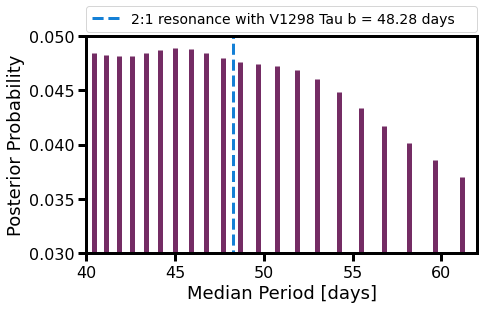

In [327]:
p = np.mean(np.exp([cpost[f"logl_{n}"].data - 
                    cpost["logl"].data for n in range(38, 60)]), axis=(1,2))
period = np.nanmedian([cpost[f"period_{n}"] for n in range(38, 60)], axis=(1,2))

plt.figure(figsize=(7,4))

for i in range(len(p)):
    plt.vlines(period[i], 0, np.abs(p[i]), lw=5, color='#742C64')
plt.vlines(period_b*2, 0,1, linestyle='--', color=parula[60], lw=3,
           label='2:1 resonance with V1298 Tau b = {} days'.format(np.round(period_b*2,2)))
plt.ylim(0.03,0.05)
plt.xlabel('Median Period [days]', fontsize=18)
plt.ylabel('Posterior Probability', fontsize=18)
plt.legend(fontsize=14,bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlim(40,62)
plt.savefig('/Users/arcticfox/Documents/v1298tau/tess/paper/periode.pdf', 
            bbox_inches='tight', dpi=250,
            rasterize=True)

In [301]:
az.summary(combined).to_csv('trace_planete_new_model_full.csv')

In [350]:
period[np.flip(np.argsort(p))]

array([45.0033391 , 45.86878793, 44.16994393, 40.42672835, 43.36685405,
       46.76817593, 41.1237409 , 42.59244594, 41.84521004, 47.70353945,
       48.67708107, 49.69118693, 50.74844622, 51.85167331, 53.00393272,
       54.20856756, 55.46923192, 56.78992792, 58.17504811, 59.62942431,
       61.15838391, 62.76781507])

In [6]:
from astropy.table import Table
combined = Table.read('/Users/arcticfox/Documents/v1298tau/tess/v1298tau_e/trace_planete_new_model_full.csv')

In [7]:
combined

col0,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64
log_depth_ktwo,1.606,0.133,1.353,1.857,0.001,0.001,13929.0,9867.0,1.0
t0,2263.622,0.004,2263.615,2263.63,0.0,0.0,18710.0,11356.0,1.0
tn,4648.799,0.002,4648.795,4648.804,0.0,0.0,16242.0,10894.0,1.0
mean_ktwo,0.001,0.1,-0.187,0.187,0.001,0.001,21285.0,11765.0,1.0
log_rho_sho_ktwo,2.119,0.69,0.896,3.444,0.006,0.005,13450.0,8984.0,1.0
log_sigma_sho_ktwo,3.374,0.807,2.046,4.925,0.008,0.006,13358.0,7502.0,1.0
mean_tess,0.001,0.1,-0.181,0.192,0.001,0.001,18985.0,12017.0,1.0
log_rho_sho_tess,0.585,0.471,-0.182,1.496,0.005,0.004,10631.0,6767.0,1.0
log_sigma_sho_tess,2.09,0.603,1.155,3.196,0.007,0.005,11052.0,6261.0,1.0
